# LOAD LIBRARIES

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import eli5
from eli5.sklearn import PermutationImportance
from imblearn.combine import SMOTEENN
warnings.filterwarnings('ignore')

# LOAD DATA

In [253]:
df = pd.read_csv('telecom_customer_churn.csv')
print('The number of rows and columns are: ', df.shape)

The number of rows and columns are:  (7043, 38)


In [254]:
population = pd.read_csv('telecom_zipcode_population.csv')
print('The number of rows and columns are: ', population.shape)
print('The number of distinct zipcode: ', population['Zip Code'].nunique())

The number of rows and columns are:  (1671, 2)
The number of distinct zipcode:  1671


In [255]:
# Map the population density
df = pd.merge(df, population, how = 'left', on = 'Zip Code')

In [256]:
df.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                  

In [257]:
# Split into training and testing data
def create_train_test_label(df, status_col='Customer Status', label_col='label', train_size=0.9, random_state=42):
    """Creates train/test label while preserving status distribution."""
    dfs = []
    for status in df[status_col].unique():
        train, test = train_test_split(df[df[status_col] == status], train_size=train_size, random_state=random_state)
        train[label_col], test[label_col] = 'training', 'testing'
        dfs.extend([train, test])
    return pd.concat(dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

In [258]:
df = create_train_test_label(df)
# df for running: would not take into status Joined because this is new and no need for prediction
df_run = df[~df['Customer Status'].isin(['Joined'])]

# DATA UNDERSTANDING

In [259]:
df.groupby(['Customer Status', 'Churn Category'])['Customer ID'].nunique()

Customer Status  Churn Category 
Churned          Attitude           314
                 Competitor         841
                 Dissatisfaction    321
                 Other              182
                 Price              211
Name: Customer ID, dtype: int64

In [260]:
df.groupby(['Customer Status'])['Customer ID'].nunique()

Customer Status
Churned    1869
Joined      454
Stayed     4720
Name: Customer ID, dtype: int64

In [261]:
# To compare the distribution of some variables by Customer Status
def plot_distribution_by_customer_status(df, status_column, variable_columns):
    unique_statuses = df[status_column].unique()
    for status in unique_statuses:
        status_df = df[df[status_column] == status]
        num_variables = len(variable_columns)
        fig, axes = plt.subplots(1, num_variables, figsize=(5 * num_variables, 4))
        
        if num_variables == 1:
            axes = [axes]
        for i, variable in enumerate(variable_columns):
            if pd.api.types.is_categorical_dtype(status_df[variable]) or not pd.api.types.is_numeric_dtype(status_df[variable]):
                counts = status_df[variable].value_counts()
                axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
                axes[i].set_title(f'{variable} Distribution - Status: {status}')
                
            else:
                print(f"Warning: {variable} is not categorical for status: {status}. Pie charts are for categorical data.")
                axes[i].text(0.5, 0.5, f"{variable} is numeric", ha='center', va='center') #Display a message if variable is numeric.
                axes[i].axis('off')  
                
        plt.suptitle(f'Pie Chart Distributions for Status: {status}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [262]:
# To compare the boxplot between different customer status for different variables
def plot_boxplots_by_variable(df, status_column, variable_columns):

    for variable in variable_columns:
        if pd.api.types.is_numeric_dtype(df[variable]):
            plt.figure(figsize=(8, 6))  # Create a new figure for each variable
            sns.boxplot(x=status_column, y=variable, data=df)
            plt.title(f'Box Plot of {variable} by {status_column}')
            plt.xlabel(status_column)
            plt.ylabel(variable)
            plt.show()
        else:
            print(f"Warning: {variable} is not numeric. Box plots are for numeric data.")

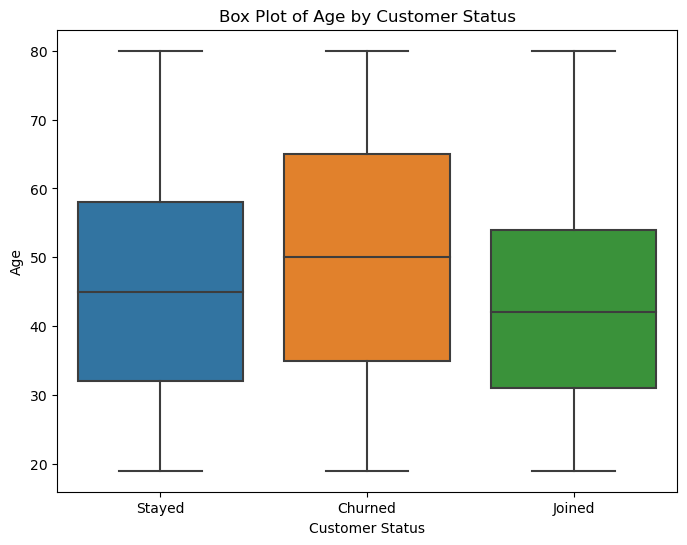

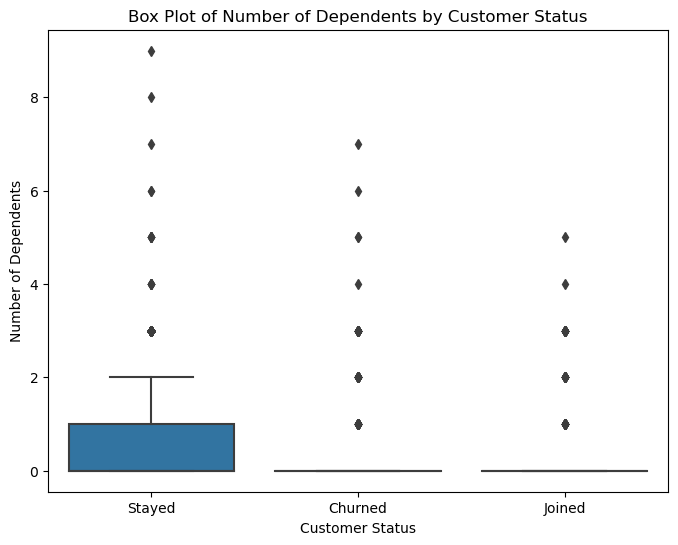

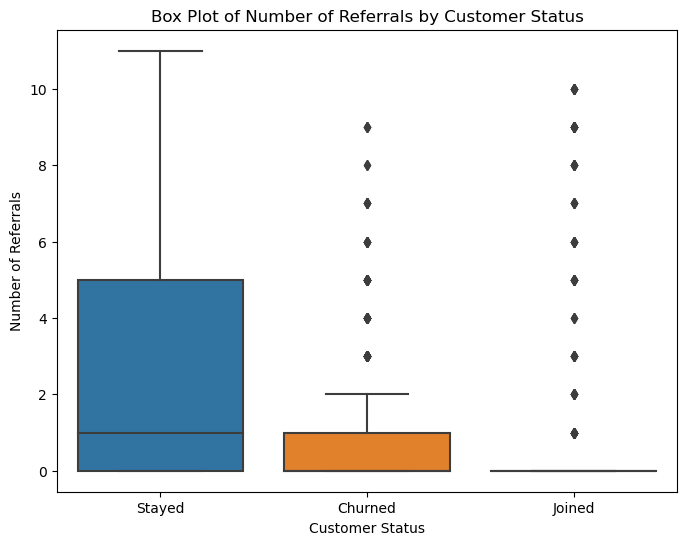

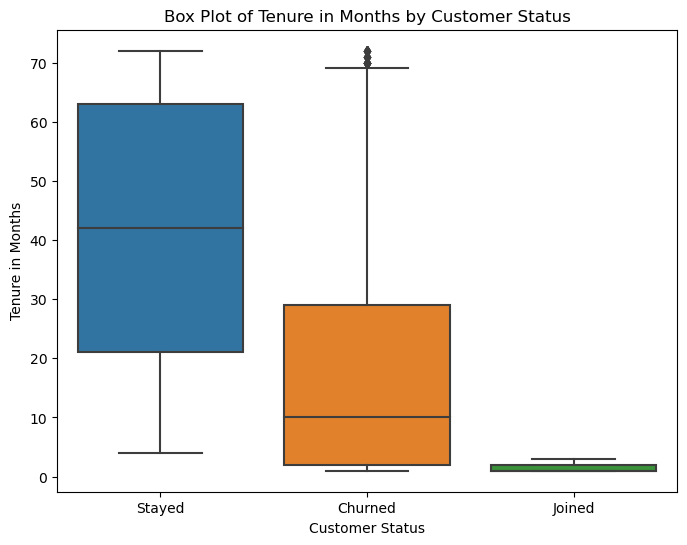

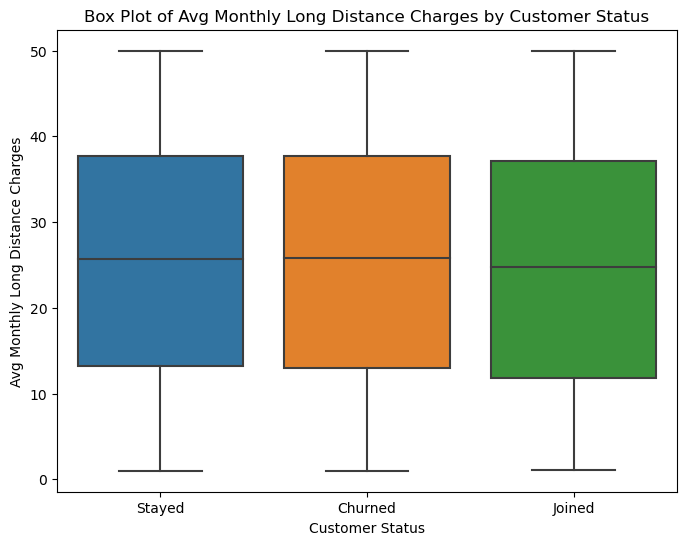

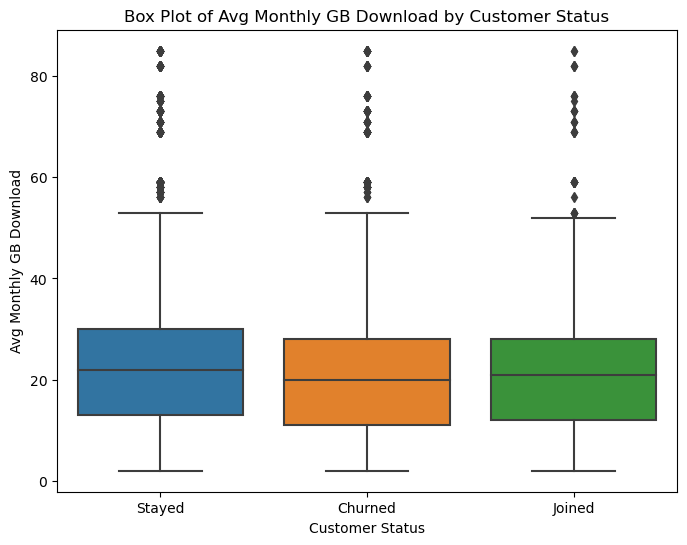

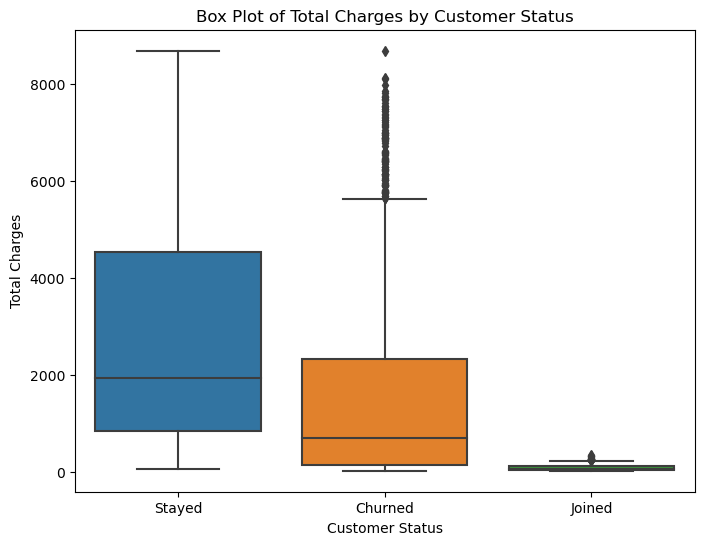

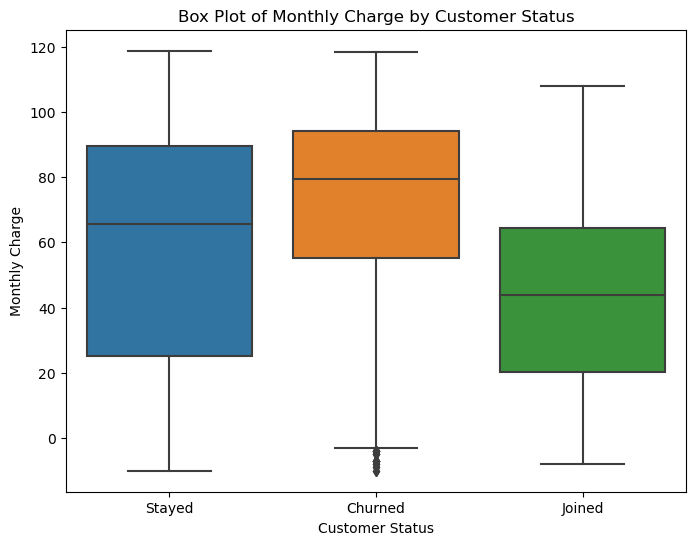

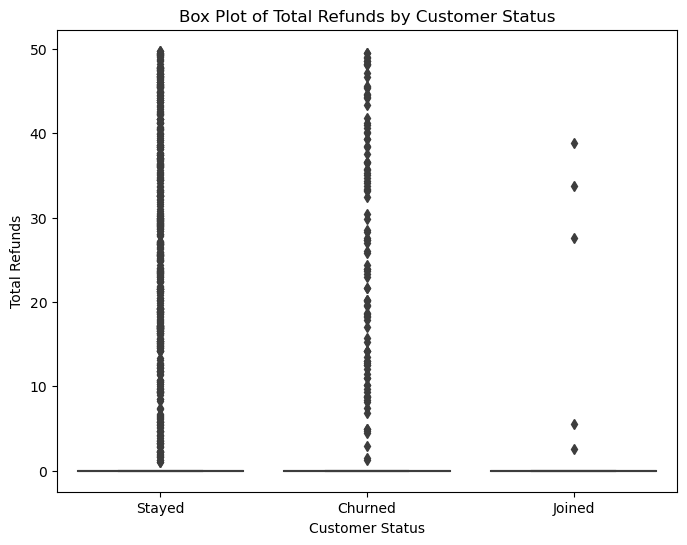

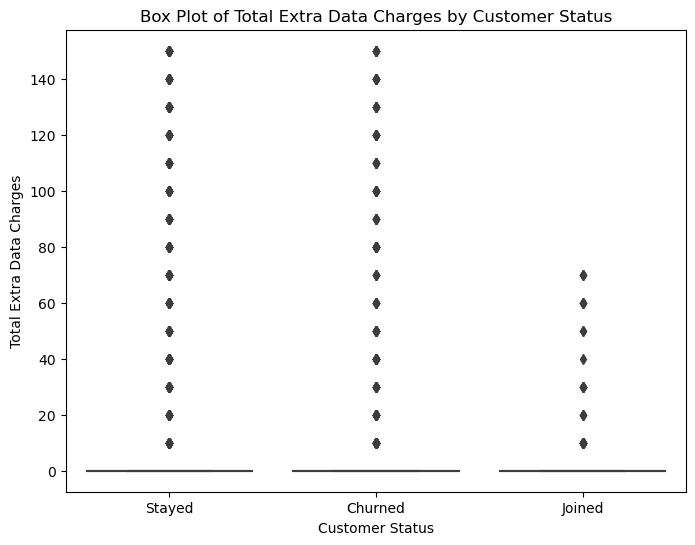

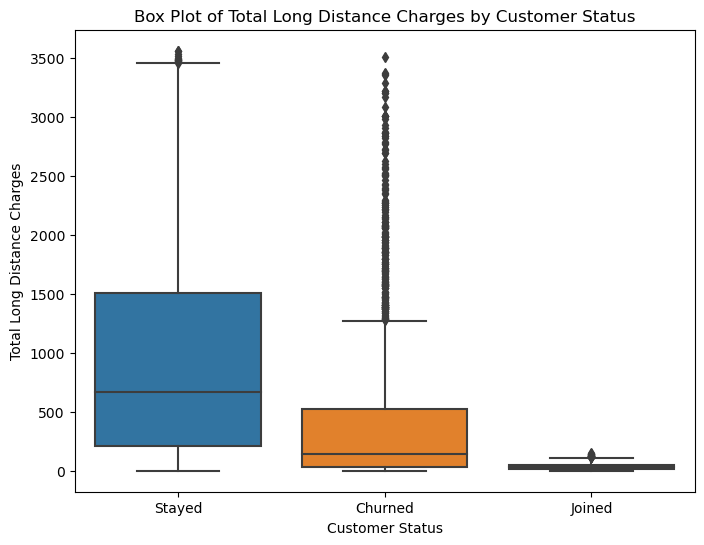

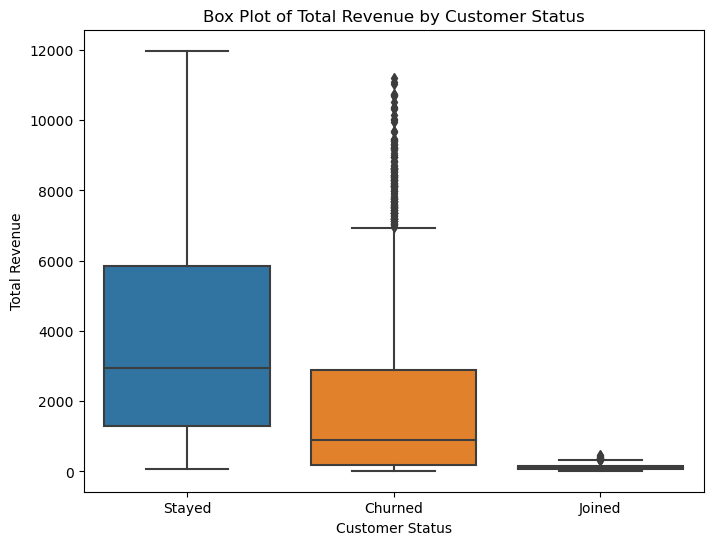

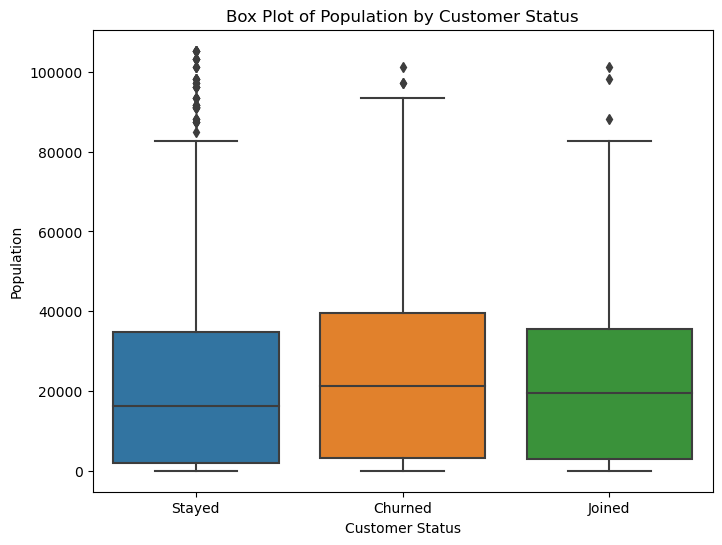

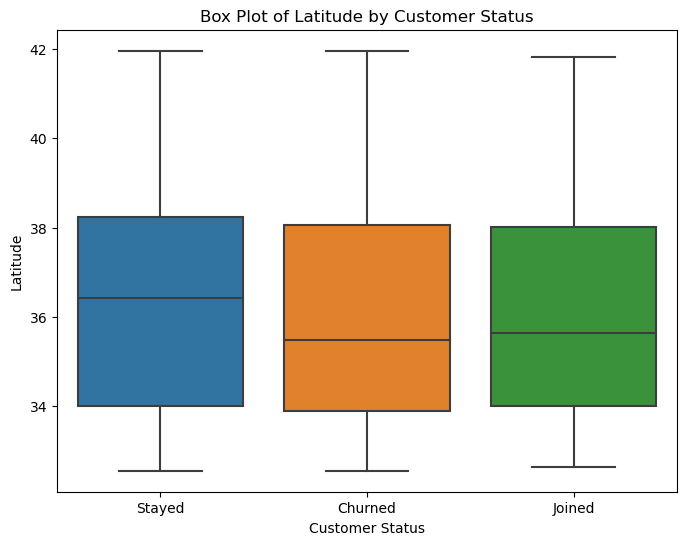

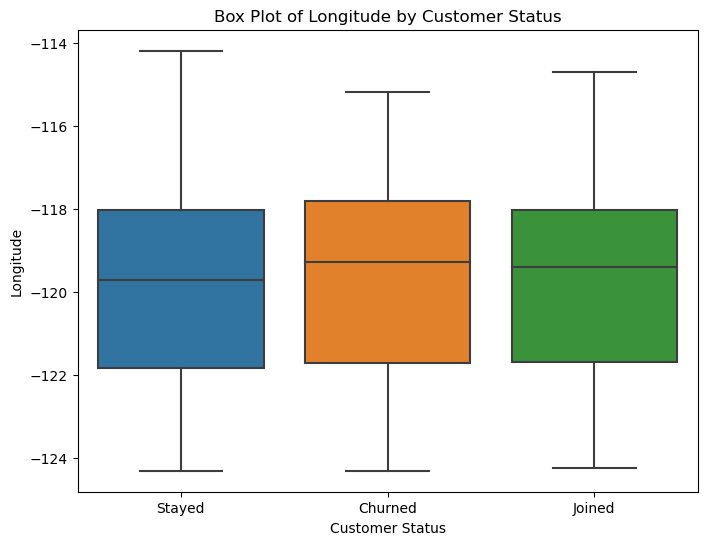

In [263]:
status_column = 'Customer Status'
continuous_columns = ['Age', 'Number of Dependents', 'Number of Referrals', 
                      'Tenure in Months', 'Avg Monthly Long Distance Charges', 
                      'Avg Monthly GB Download', 'Total Charges', 'Monthly Charge', 
                      'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges',
                      'Total Revenue', 'Population', 'Latitude', 'Longitude']

plot_boxplots_by_variable(df, status_column, continuous_columns)

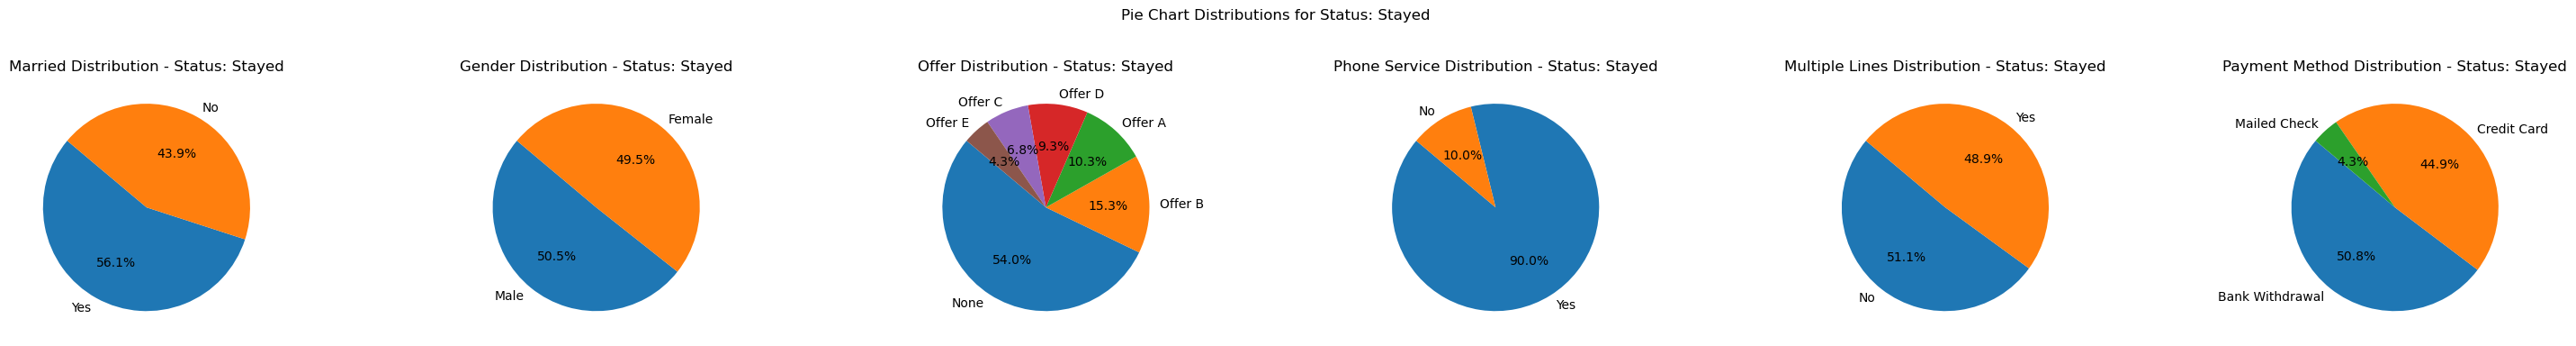

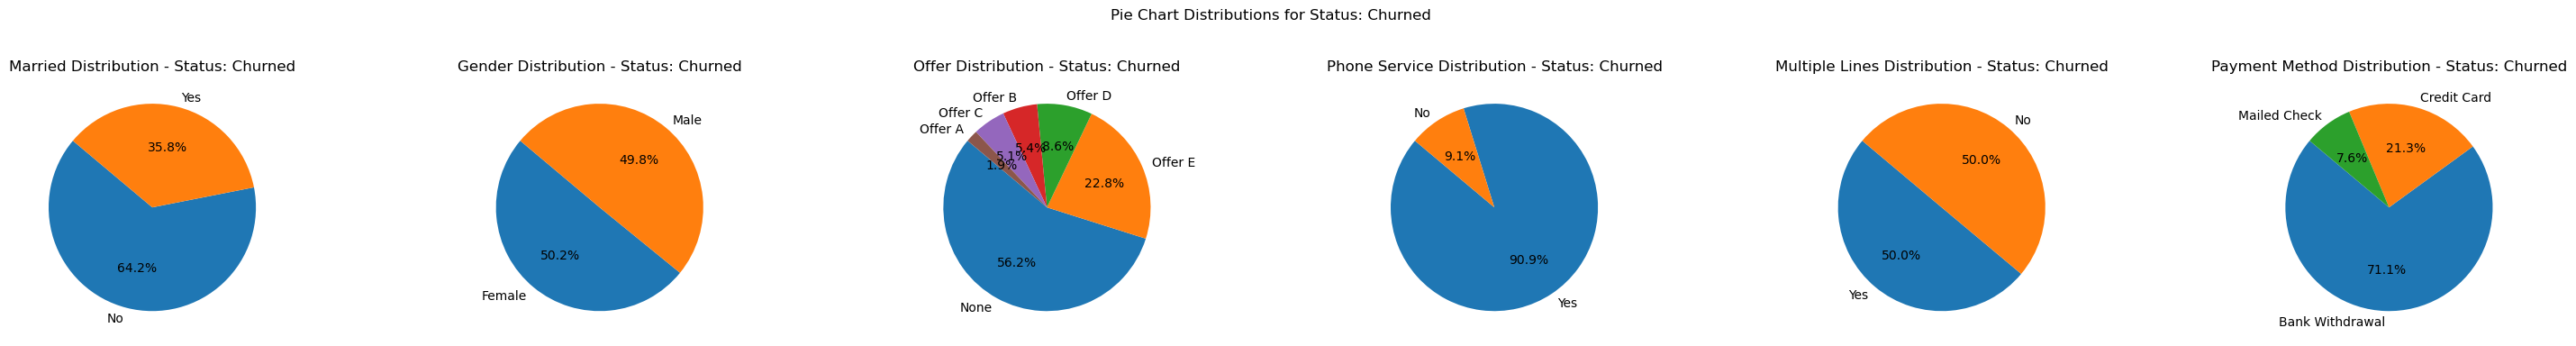

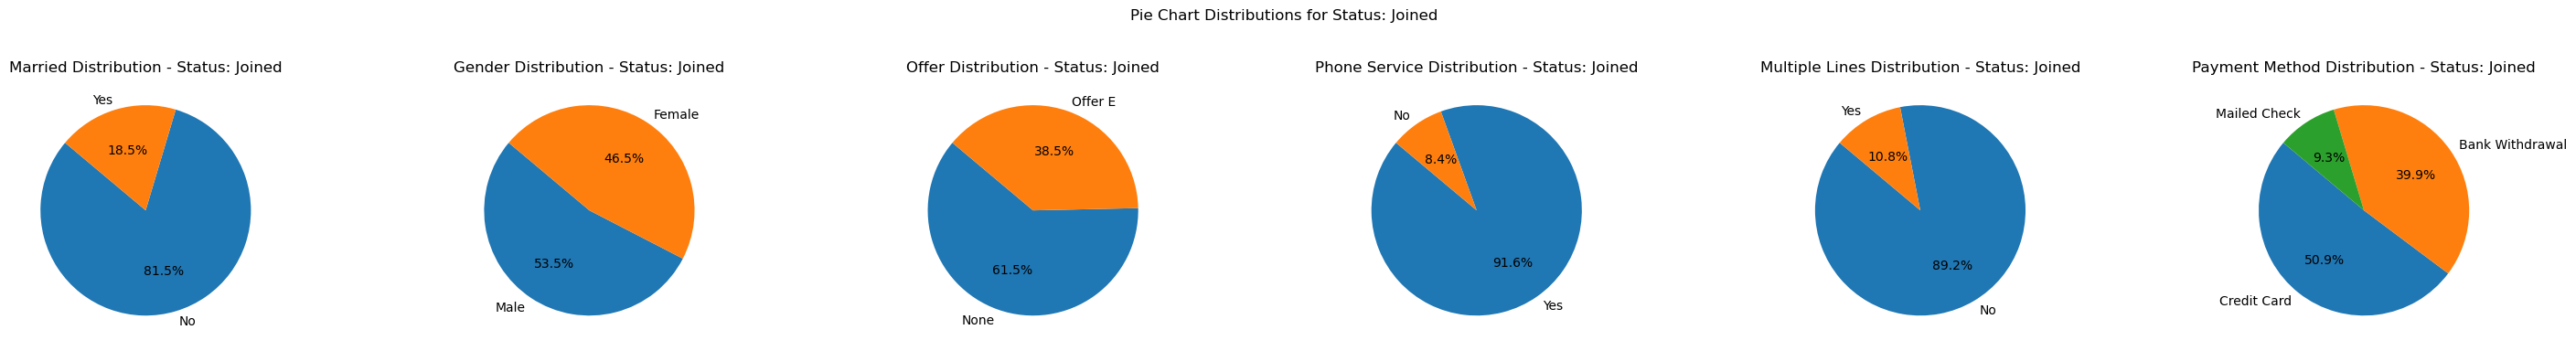

In [265]:
status_column = 'Customer Status'
variable_columns = ['Married', 'Gender', 'Offer', 
                    'Phone Service', 'Multiple Lines', 'Payment Method']
plot_distribution_by_customer_status(df, status_column, variable_columns)

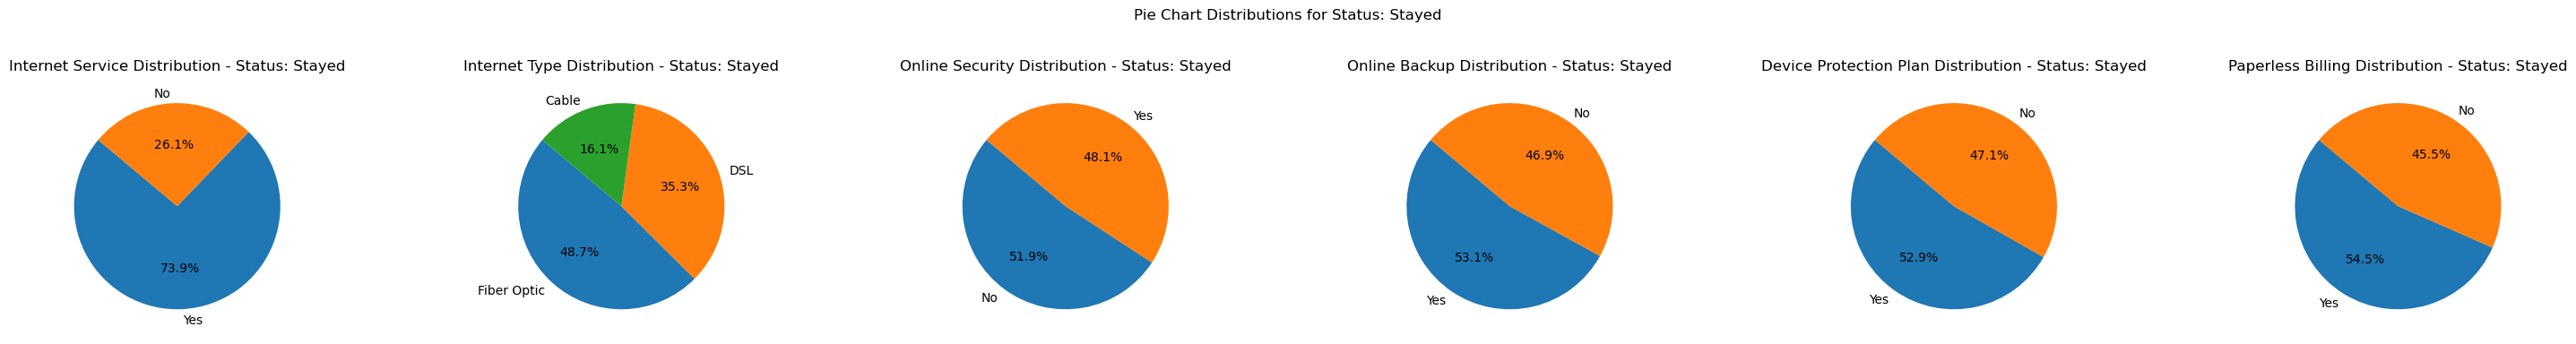

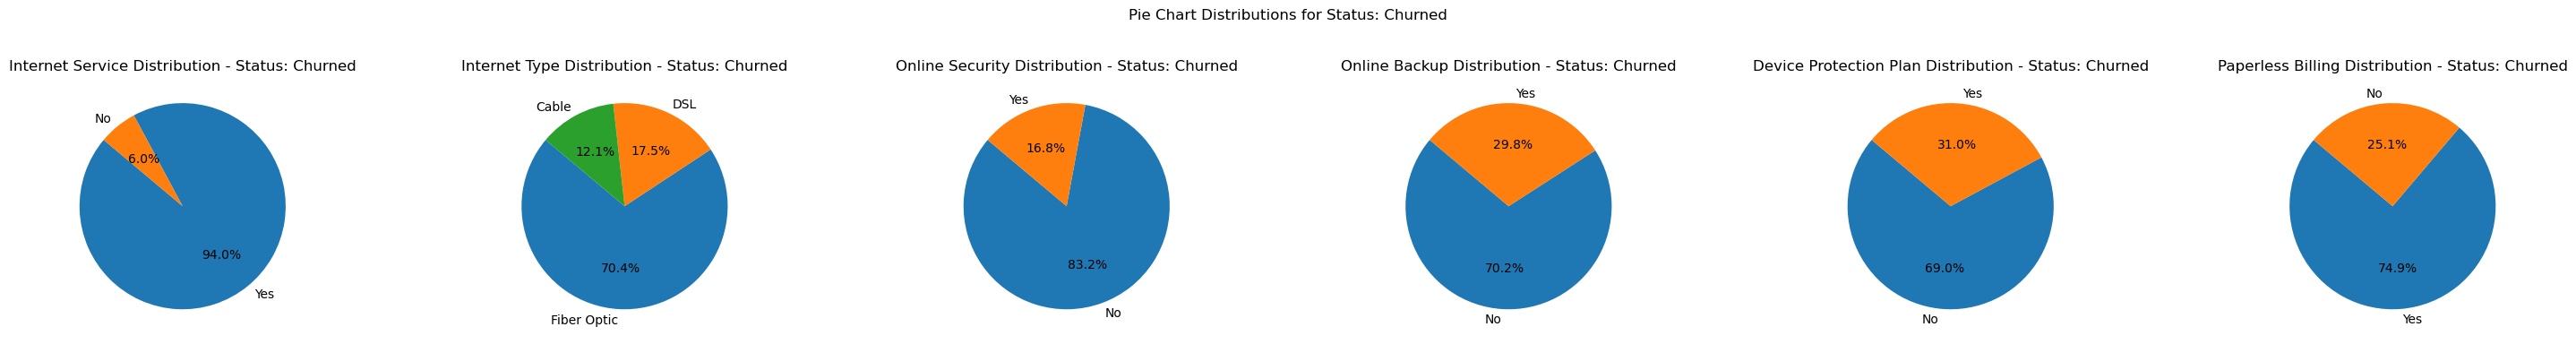

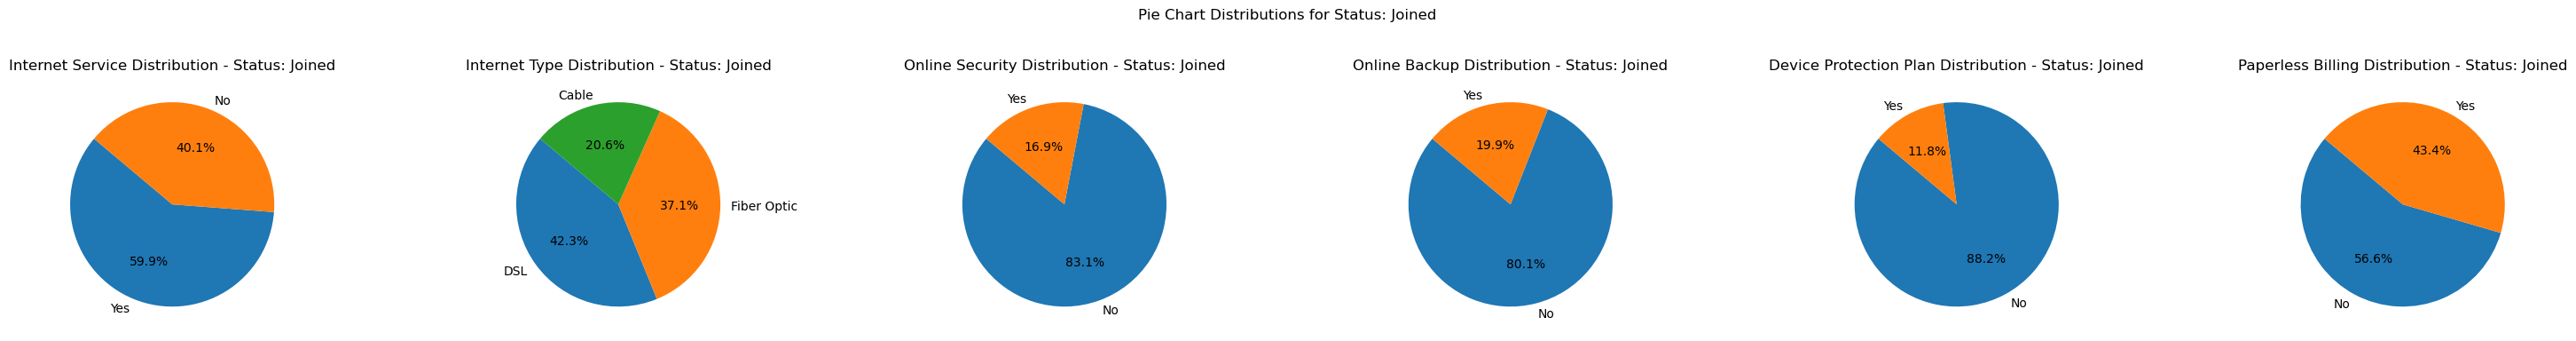

In [266]:
status_column = 'Customer Status'
variable_columns = ['Internet Service',  'Internet Type', 'Online Security', 
                    'Online Backup', 'Device Protection Plan', 'Paperless Billing']
plot_distribution_by_customer_status(df, status_column, variable_columns)

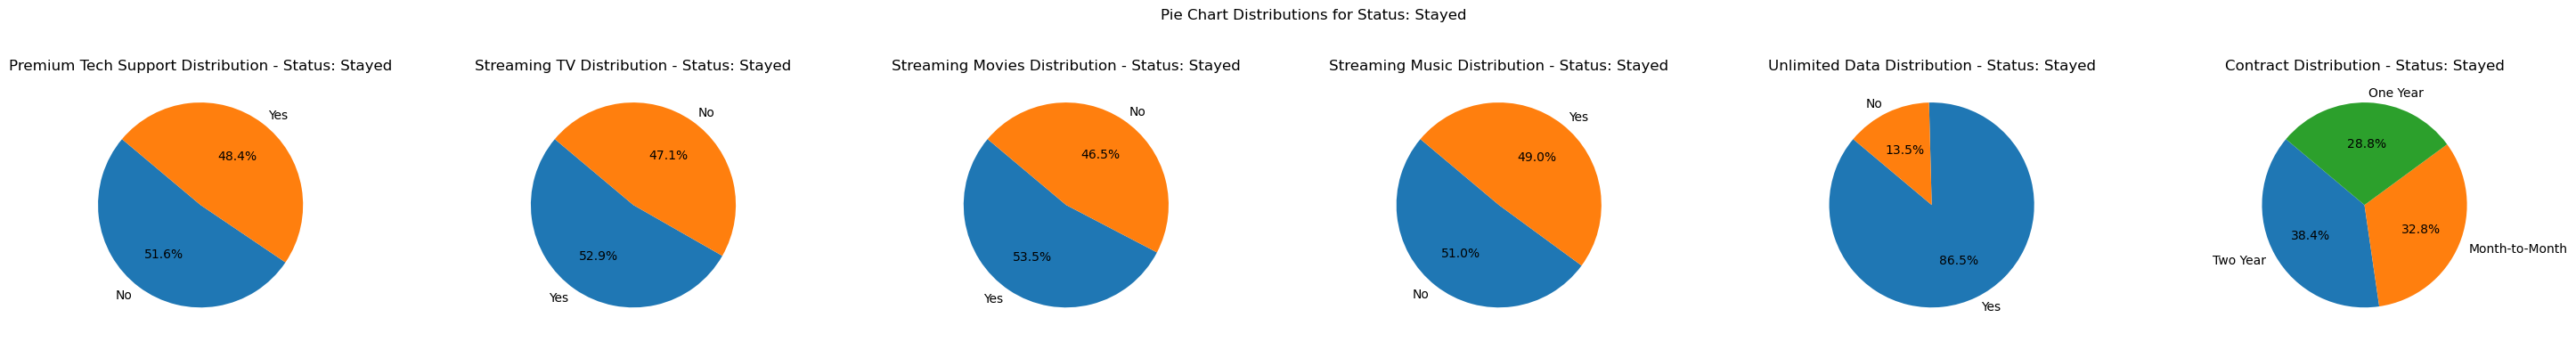

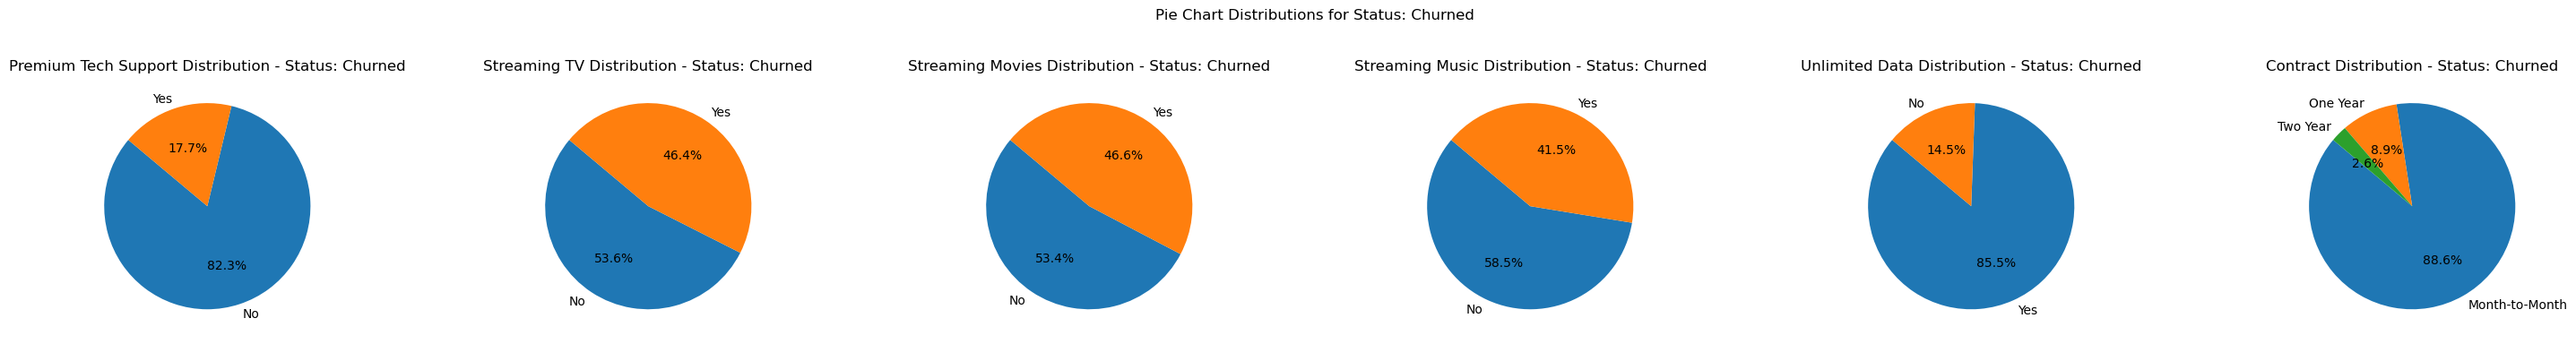

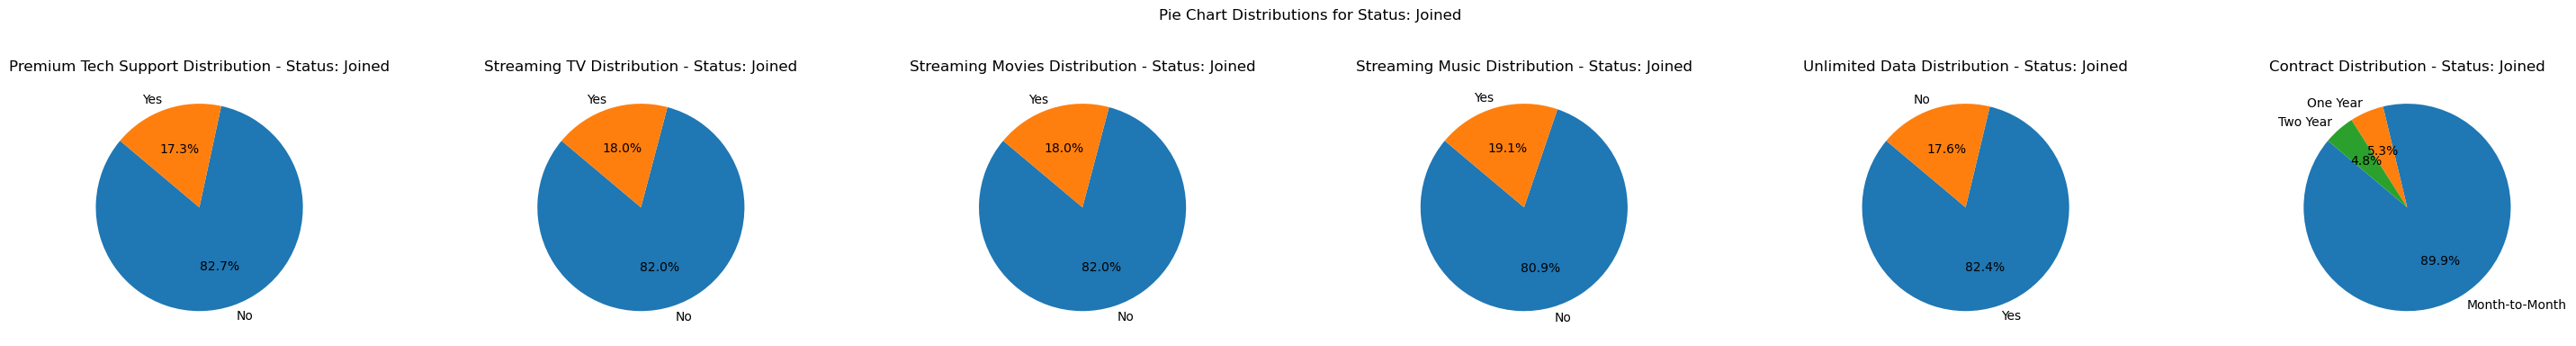

In [267]:
status_column = 'Customer Status'
variable_columns = ['Premium Tech Support', 'Streaming TV', 'Streaming Movies', 
                    'Streaming Music', 'Unlimited Data', 'Contract']
plot_distribution_by_customer_status(df, status_column, variable_columns)

1. From the pie charts, the differences between churned customers and stayed customers include these variables: Married, Offer, Payment Method, Internet Service, Internet Type, Online Security, Online Backup, Device Protection Plan, Paperless Billing, Premium Tech Support, Streaming TV, Streaming Music, Streaming Movies, Contract
2. From the box plot, the differences between churned customers and churned customers include these variables: Age, Number of Dependents, Number of Referrals, Tenure, Total Charges, Monthly Charge, Total Long Distance Charges, Total Revenue

# DATA PREPROCESSING

In [300]:
# Create a flag for offer E
df_run['OfferE'] =  (df_run['Offer'] == 'Offer E').astype(int)

In [301]:
# Process the binary variables first
def process_binary(df, list_of_columns):
    for col in list_of_columns:
        if col in ['Internet Type']:
            df[col].fillna('None', inplace=True)
        if col in ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
                  'Streaming TV', 'Streaming Music', 'Streaming Movies']:
            df[col].fillna('No', inplace=True)
        if col == 'Gender':
            df[col] = df[col].map({'Male': 1, 'Female': 0})
        if col in ['Married', 'Internet Service', 'Premium Tech Support', 
                   'Streaming TV', 'Streaming Music', 'Streaming Movies',
                   'Online Security', 'Online Backup', 'Device Protection Plan',
                   'Paperless Billing']:
            df[col] = df[col].map({'Yes': 1, 'No': 0})
        if col in ['Offer', 'Payment Method', 'Internet Type', 'Contract']:
            # Perform one-hot encoding using get_dummies
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col]) 
    return df

# Process the continuous columns
def process_continuous(df, list_of_columns):
    scaler = RobustScaler()
#     scaler = StandardScaler()
    df_scaled = df.copy()
    for col in list_of_columns:
        if col in df_scaled.columns:
            df_scaled[col] = scaler.fit_transform(df_scaled[[col]])
    return df_scaled    
    
binary_col_list = ['Married', 'Offer', 'Payment Method', 'Internet Service', 'Internet Type', 'Online Security', 
                   'Online Backup', 'Device Protection Plan', 'Paperless Billing', 'Premium Tech Support', 'Streaming TV', 
                   'Streaming Music', 'Streaming Movies', 'Contract']
continuous_col_list = ['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months',
                      'Total Charges', 'Monthly Charge', 'Total Long Distance Charges', 'Total Revenue', 'Latitude']
target_col_list = ['label', 'Customer Status']

chosen_col_v2 = ['Contract',  'Number of Referrals', 'Number of Dependents', 'Monthly Charge', 
                 'Tenure in Months', 'Age', 'Internet Service', 
                 'Total Revenue', 'Total Long Distance Charges',
                 'Streaming Music', 'Latitude', 'Online Backup', 'Streaming Movies',
                 'Payment Method', 'Internet Type', 'Paperless Billing', 'Device Protection Plan', 'OfferE', 'Married']

# apply_col = binary_col_list + continuous_col_list + target_col_list
apply_col = chosen_col_v2 + target_col_list
df_apply = df_run[apply_col]

# df_process = process_binary(df_apply, binary_col_list)
# df_process = process_continuous(df_process, continuous_col_list)

df_process = process_binary(df_apply, chosen_col_v2)
df_process = process_continuous(df_process, chosen_col_v2)

df_process['churned'] = df_process['Customer Status'].map({'Churned': 1, 'Stayed': 0})

# Remove unnecessary columns
unnecessary_cols_list = ['Customer ID', 'Gender', 'City', 
                         'Zip Code', 'Phone Service', 'Multiple Lines',
                         'Churn Category', 'Churn Reason', 'Customer Status', 'Avg Monthly GB Download',
                         'Longitude']
df_process = df_process.drop(columns=[col for col in unnecessary_cols_list if col in df_process.columns], errors='ignore')

# BUILD MODEL

For this challenge, choose the metric F1 score

In [276]:
train = df_process[df_process['label']=='training'].drop('label', axis=1)
test = df_process[df_process['label']=='testing'].drop('label', axis=1)

In [277]:
# Create training and testing data first
X = train.drop('churned',axis=1)
y = train['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_final = test.drop('churned', axis = 1)
y_final = test['churned']

In [278]:
def print_report(model,X_test,y_test,y_pred):
    """
    returns the model score, confusion matrix and classfication report
    """
    print("Model Score : {} \n ".format(model.score(X_test, y_test)))
    print("Confusion Matrix : \n {}\n".format(confusion_matrix(y_test,y_pred)))
    print("Accuracy : {}".format( round(accuracy_score(y_test, y_pred)*100, 2)))
    print("Classification report : \n\n"+classification_report(y_test, y_pred, labels=[0,1]))

## DECISION TREE CLASSIFIER

In [22]:
dt_model = DecisionTreeClassifier(criterion='gini',max_depth=3, min_samples_leaf=8)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print_report(dt_model, X_test, y_test, y_pred)

Model Score : 0.8507588532883642 
 
Confusion Matrix : 
 [[851  14]
 [163 158]]

Accuracy : 85.08
Classification report : 

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       865
           1       0.92      0.49      0.64       321

    accuracy                           0.85      1186
   macro avg       0.88      0.74      0.77      1186
weighted avg       0.86      0.85      0.83      1186



In [23]:
y_final_pred = dt_model.predict(X_final)
print_report(dt_model, X_final, y_final, y_final_pred)

Model Score : 0.8376327769347496 
 
Confusion Matrix : 
 [[458  14]
 [ 93  94]]

Accuracy : 83.76
Classification report : 

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       472
           1       0.87      0.50      0.64       187

    accuracy                           0.84       659
   macro avg       0.85      0.74      0.77       659
weighted avg       0.84      0.84      0.82       659



## SMOTEEN METHODS

In [286]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [287]:
print("Before OverSampling- counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling- counts of label '0': {} \n".format(sum(y_train==0)))
print("After OverSampling with SMOTEENN - '1': {}".format(sum(y_resampled==1)))
print("After OverSampling with SMOTEENN - '0': {}".format(sum(y_resampled==0)))

Before OverSampling- counts of label '1': 1361
Before OverSampling- counts of label '0': 3383 

After OverSampling with SMOTEENN - '1': 2650
After OverSampling with SMOTEENN - '0': 2223


In [288]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled, test_size = 0.1)

In [289]:
dt_model_r = DecisionTreeClassifier(criterion='gini',max_depth=3, min_samples_leaf=8)
dt_model_r.fit(Xr_train, yr_train)
yr_pred = dt_model_r.predict(Xr_test)
print_report(dt_model_r, Xr_test, yr_test, yr_pred)

Model Score : 0.9262295081967213 
 
Confusion Matrix : 
 [[199  25]
 [ 11 253]]

Accuracy : 92.62
Classification report : 

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       224
           1       0.91      0.96      0.93       264

    accuracy                           0.93       488
   macro avg       0.93      0.92      0.93       488
weighted avg       0.93      0.93      0.93       488



In [290]:
y_final_pred = dt_model_r.predict(X_final)
print_report(dt_model_r, X_final, y_final, y_final_pred)

Model Score : 0.7253414264036419 
 
Confusion Matrix : 
 [[311 161]
 [ 20 167]]

Accuracy : 72.53
Classification report : 

              precision    recall  f1-score   support

           0       0.94      0.66      0.77       472
           1       0.51      0.89      0.65       187

    accuracy                           0.73       659
   macro avg       0.72      0.78      0.71       659
weighted avg       0.82      0.73      0.74       659



With SMOTEENN method, the recall is high but precision is too low

## Random Forest Classifier

In [302]:
# Define param grid
param_grid = {
    'n_estimators': [100, 200, 250, 300],
    'max_depth': [5, 8, 10, 20],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6, 8]
}

rf = RandomForestClassifier(random_state=42)

# Define Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1) 

grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Make predictions based on best parameters
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 200}
Best Score: 0.8703636517231107


In [303]:
y_final_pred = best_rf.predict(X_final)
print_report(best_rf, X_final, y_final, y_final_pred)

Model Score : 0.866464339908953 
 
Confusion Matrix : 
 [[439  33]
 [ 55 132]]

Accuracy : 86.65
Classification report : 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       472
           1       0.80      0.71      0.75       187

    accuracy                           0.87       659
   macro avg       0.84      0.82      0.83       659
weighted avg       0.86      0.87      0.86       659



In [192]:
perm = PermutationImportance(best_rf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0393 ± 0.0063,Contract_Month-to-Month
0.0172 ± 0.0048,Number of Referrals
0.0096 ± 0.0035,Contract_Two Year
0.0084 ± 0.0051,Number of Dependents
0.0067 ± 0.0028,Monthly Charge
0.0064 ± 0.0109,Tenure in Months
0.0059 ± 0.0081,Age
0.0032 ± 0.0046,Internet Service
0.0029 ± 0.0031,Total Revenue
0.0024 ± 0.0050,Total Long Distance Charges


From feature importance, select fewer dimensions to verify if they affect the overall performance

## XGBOOST

In [305]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1) 
grid_search.fit(X_train, y_train)
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Make predictions based on best parameters
best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Best Score: 0.8825889666933477


In [306]:
y_final_pred = best_xgb.predict(X_final)
print_report(best_xgb, X_final, y_final, y_final_pred)

Model Score : 0.8634294385432474 
 
Confusion Matrix : 
 [[434  38]
 [ 52 135]]

Accuracy : 86.34
Classification report : 

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       472
           1       0.78      0.72      0.75       187

    accuracy                           0.86       659
   macro avg       0.84      0.82      0.83       659
weighted avg       0.86      0.86      0.86       659



## LIGHT GRADIENT BOOSTING (LGBM)

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 5, 6],
    'num_leaves': [20, 30, 40],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.1, 0.5], #L1 regularization.
    'reg_lambda': [0.1, 0.5] #L2 regularization.
}

# LightGBM classifier
lgbm_clf = lgb.LGBMClassifier(objective='binary', random_state=42)

# GridSearchCV object
grid_search = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Make predictions based on best parameters
best_lgbm = grid_search.best_estimator_

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1361, number of negative: 3383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 4744, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286889 -> initscore=-0.910543
[LightGBM] [Info] Start training from score -0.910543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [24]:
y_final_pred = best_lgbm.predict(X_final)
print_report(best_lgbm, X_final, y_final, y_final_pred)

Model Score : 0.8649468892261002 
 
Confusion Matrix : 
 [[432  40]
 [ 49 138]]

Accuracy : 86.49
Classification report : 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       472
           1       0.78      0.74      0.76       187

    accuracy                           0.86       659
   macro avg       0.84      0.83      0.83       659
weighted avg       0.86      0.86      0.86       659

